In [28]:
import pandas as pd 
import numpy as np

In [25]:
df = pd.read_csv('website_data.csv')

df.head()

,traffic
0,932
1,929
2,938
3,964
4,990


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<Axes: >

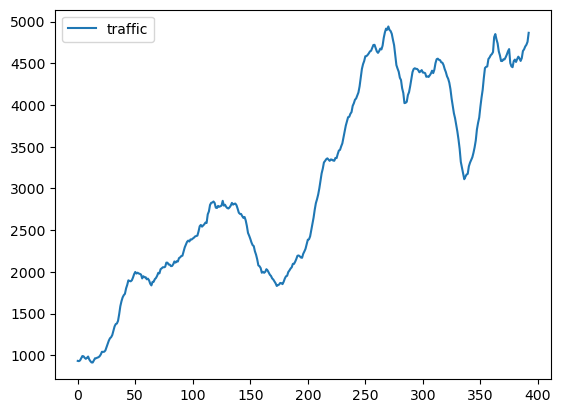

In [26]:
df.plot()

In [29]:
df = np.log(df)

<Axes: >

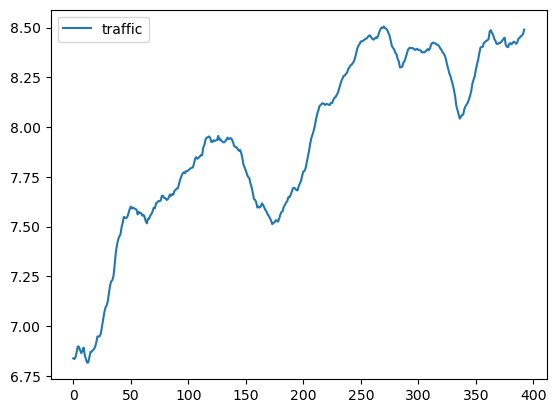

In [30]:
df.plot()

In [31]:
msk = (df.index < len(df)-30)

df_train = df[msk].copy()
df_test = df[~msk].copy()

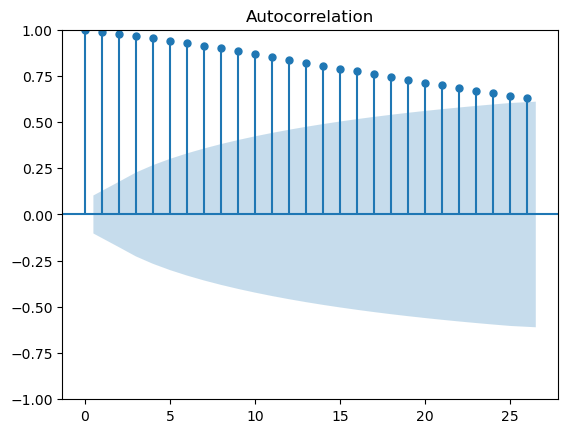

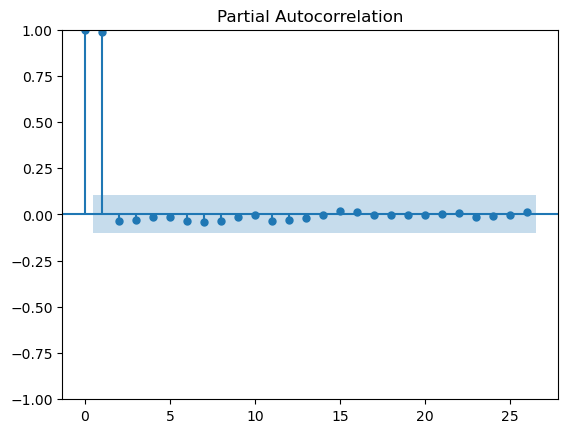

In [32]:
# Check for ACF and PACF 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [35]:
from statsmodels.tsa.stattools import adfuller 

adf_test = adfuller(df_train)

print(f"P-Value = {adf_test[1]}")

P-Value = 0.24126116082883475


<Axes: >

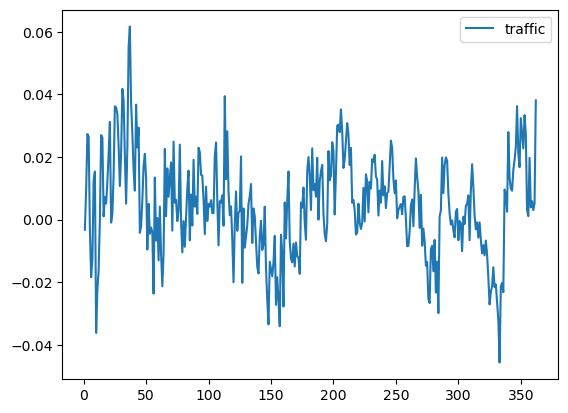

In [36]:
# Dickey Fuller test shows that there is a unit root (non stationary)

df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

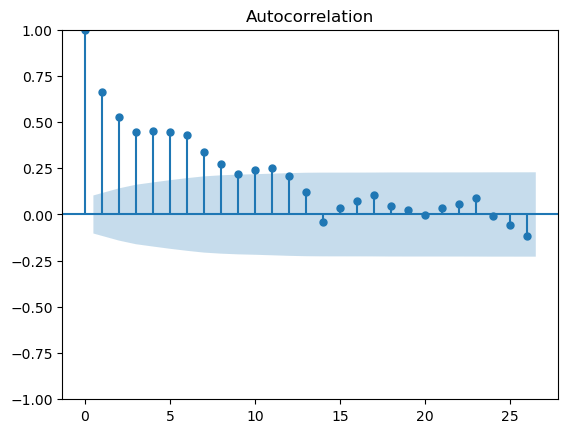

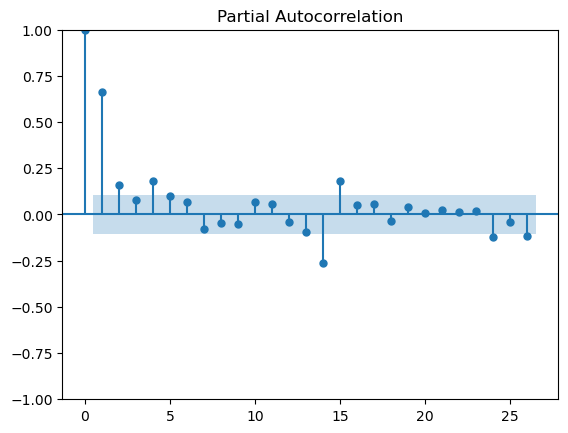

In [37]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [38]:
# Using the ADF test again

adf_test = adfuller(df_train_diff)
print(f"P-Value = {adf_test[1]}")

P-Value = 0.02205946123912647


In [40]:
# This shows that the value for 'd' should be 1 
# fit the ARIMA Model

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_train, order=(2,1,0))
arima_model_fit = arima_model.fit()

arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Wed, 11 Dec 2024   AIC                          -2186.737
Time:                        11:47:39   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                17.76
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

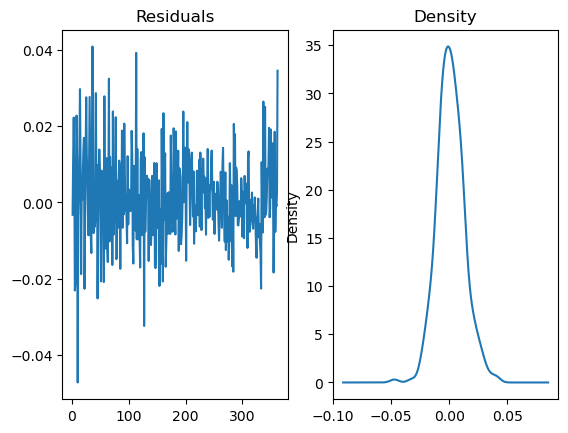

In [41]:
# Making time series predictions 

import matplotlib.pyplot as plt 

residuals = arima_model_fit.resid[1:]

fig,ax = plt.subplots(1,2)

residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

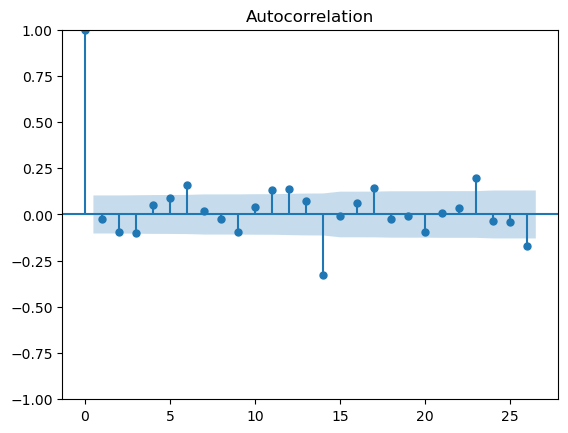

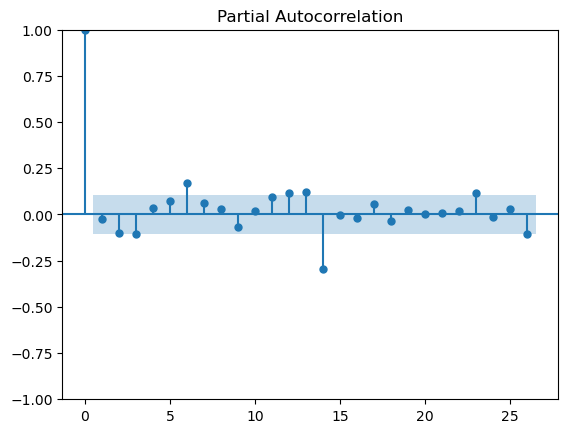

In [42]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<Axes: >

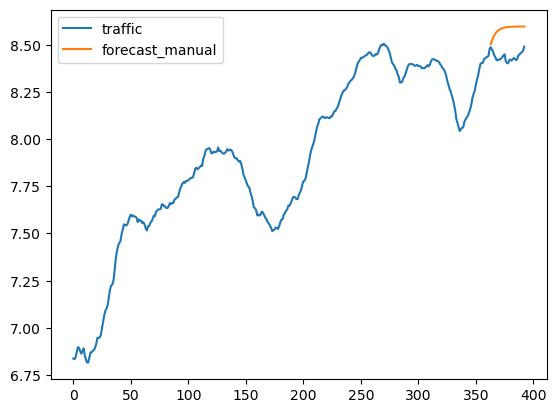

In [43]:
forecast_test = arima_model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [44]:
# Autofitting the ARIMA model 

import pmdarima as pm 

auto_arima = pm.auto_arima(df_train, stepwise= False, seasonal = False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

<Axes: >

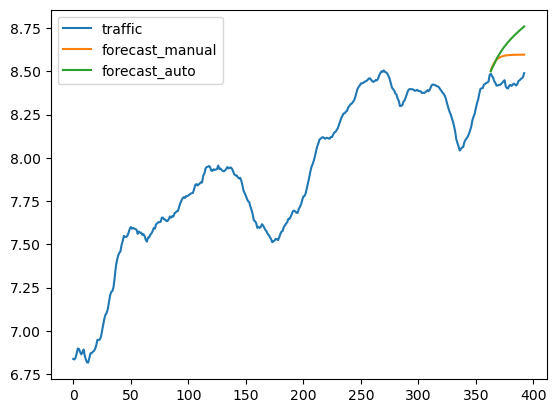

In [46]:
# Evalauting the model predictions 

forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

Manually fitted model is actually closer to the actual value

In [47]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual = {mae}')
print(f'mape - manual = {mape}')
print(f'rmse - manual = {rmse}')

mae - manual = 0.14514968388076604
mape - manual = 0.017216198515850756
rmse - manual = 0.15051403899106064


In [48]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - manual = {mae}')
print(f'mape - manual = {mape}')
print(f'rmse - manual = {rmse}')

mae - manual = 0.2169602988634135
mape - manual = 0.02572661513199039
rmse - manual = 0.23124757348892572
